# Preeclampsia Risk Prediction using MLP Networks

Este cuaderno es la continuación de 01-preeclampsia-risk-prediction-using-MLP
ya que hemos creado un nuevo dataset para el wearable a partir de los datos de synthea y no a aprtir del dataset de Maternal Health riisk En el nuevo sólo se incluirá datos capturados directamente del wearable. Factores como la edad, BMI, Hemoglobina o HDL no serán incluidos en este dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
train_df = pd.read_excel('train_dataset.xlsx')
test_df = pd.read_excel('test_dataset.xlsx')

In [5]:
train_df.columns

Index(['gravida', 'parity', 'gestational age (weeks)', 'Age (yrs)',
       'BMI  [kg/m²]', 'diabetes', 'History of hypertension (y/n)',
       'Systolic BP', 'Diastolic BP', 'HB', 'fetal weight(kgs)',
       'Protien Uria', 'Unnamed: 12',
       'Uterine Artery Doppler Resistance Index (RI)',
       ' Uterine Artery Doppler Pulsatility Index (PI',
       'amniotic fluid levels(cm)', 'Risk_level'],
      dtype='object')

In [7]:
columns_to_drop = [
    'gravida', 
    'parity',  'gestational age (weeks)', 
    'Age (yrs)', 'BMI  [kg/m²]', 'diabetes', 'History of hypertension (y/n)',
    'fetal weight(kgs)',
       'Protien Uria', 'Unnamed: 12',
       'Uterine Artery Doppler Resistance Index (RI)',
       ' Uterine Artery Doppler Pulsatility Index (PI',
       'amniotic fluid levels(cm)','HB'
]
train_df.drop(columns_to_drop, axis = 1, inplace=True)
test_df.drop(columns_to_drop, axis = 1, inplace=True)

In [9]:
train_df

,Systolic BP,Diastolic BP,Risk_level
0,130,80,mid
1,110,60,low
2,110,60,mid
3,110,70,low
4,120,80,mid
...,...,...,...
157,110,70,mid
158,110,70,low
159,110,60,mid
160,110,70,low


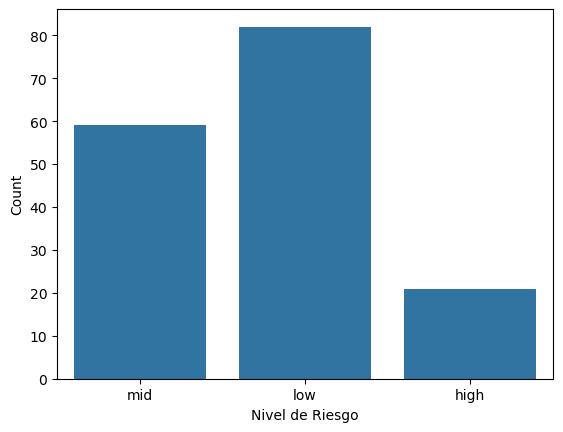

In [11]:
import matplotlib.pyplot as plt
train_df['Risk_level'] = train_df['Risk_level'].str.strip().str.lower() #elimina espacios y convierte a minúsculas
train_df['Risk_level'] = train_df['Risk_level'].replace({'low':'low'}) #unificamos nombre
sns.countplot(x='Risk_level', data = train_df)
plt.ylabel('Count')
plt.xlabel('Nivel de Riesgo')
plt.show()


## IMPLEMENTACIÓN DEL ALGORITMO

In [14]:
selected_features = ["Systolic BP", "Diastolic BP" ]
X_train = train_df[selected_features]
X_test = test_df[selected_features]

#Variable objetivo
y_train= train_df['Risk_level']
y_test = test_df['Risk_level']

In [16]:
from sklearn.preprocessing import StandardScaler
# Preprocesamiento: estandarización de las variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
from sklearn.preprocessing import LabelEncoder

#codificamos variable objetivo: risk level
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Para hacer una clasificación de 3 clases, usaos one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

### BUILIDNG MLP MODEL

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [23]:
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    
    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    
    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    
    Dense(y_train_categorical.shape[1], activation='softmax')
])


# Compiling the Model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])


 # tf.keras.optimizers.SGD(learning_rate=0.001)
# model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy']) con este conseguimos un 70% accuracy pero muy overfitted


C:\Users\virginia.anton\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\virginia.anton\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


###  TRAINING THE MODEL

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convertir one-hot encoding a etiquetas
y_train_labels = np.argmax(y_train_categorical, axis=1)

# Calcular los pesos de clase
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_labels),
                                     y=y_train_labels)

# Convertir a diccionario para Keras
class_weights = dict(enumerate(class_weights))

# Entrenar el modelo con pesos de clase
history = model.fit(X_train_scaled, y_train_categorical, epochs=150, batch_size=32,
                    validation_data=(X_train_scaled, y_train_categorical),
                    class_weight=class_weights)


Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3327 - loss: 0.8782 - val_accuracy: 0.3642 - val_loss: 0.6966
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3966 - loss: 0.8176 - val_accuracy: 0.3642 - val_loss: 0.6950
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4358 - loss: 0.8111 - val_accuracy: 0.3642 - val_loss: 0.6943
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3202 - loss: 0.8020 - val_accuracy: 0.3272 - val_loss: 0.6927
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3543 - loss: 0.7780 - val_accuracy: 0.3272 - val_loss: 0.6907
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4377 - loss: 0.7900 - val_accuracy: 0.3272 - val_loss: 0.6891
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4485 - loss: 0.8225 - val_accuracy: 0.3333 - val_loss: 0.6877
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3649 - loss: 0.8334 - val_accuracy: 0.3333 - val_loss:

In [28]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_categorical)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7378 - loss: 0.4487
Test Accuracy: 73.17%


In [30]:
y_pred_prob = model.predict(X_test_scaled)
y_pred_encoded = np.argmax(y_pred_prob, axis=1)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [32]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        high       0.33      0.20      0.25         5
         low       0.88      0.88      0.88        25
         mid       0.54      0.64      0.58        11

    accuracy                           0.73        41
   macro avg       0.58      0.57      0.57        41
weighted avg       0.72      0.73      0.72        41



El modelo reconoce pocas pacientes con preeclampsia ya que el dataset está desbalanceado,  y por tanto aprende más patrone sy reconoce mejor las otras clases. 

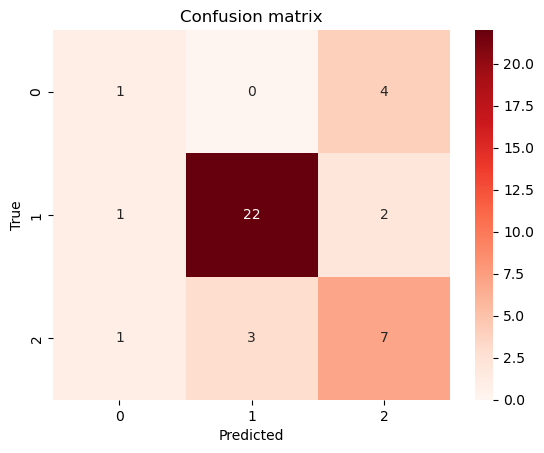

In [35]:
from sklearn.metrics import confusion_matrix
#Visualizamos resultados
confusion_matrix= confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

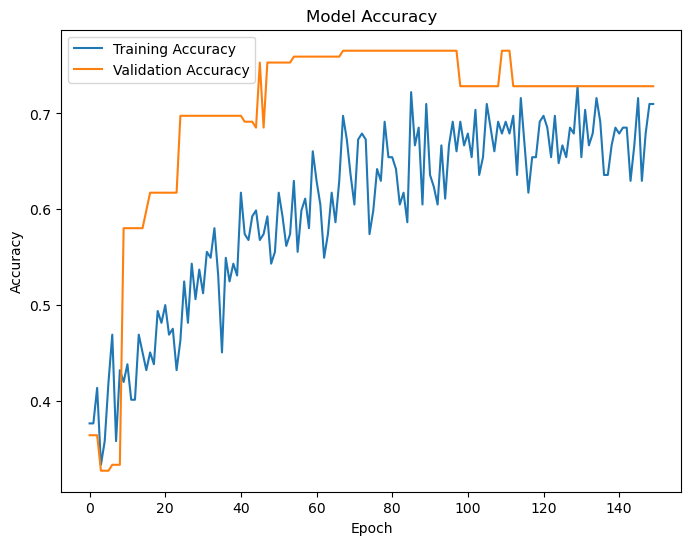

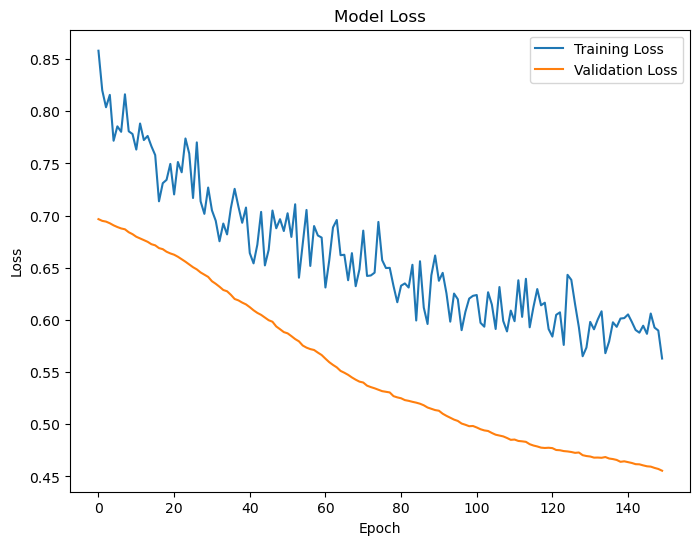

In [37]:
# Accuracy Plot
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
model.save('mlp-modell_WEARABLE.keras')

## PRUEBA CON DATOS WEARABLE

In [113]:
wearable = pd.read_csv('wearable_MaternalRiskDatasetUnknownAge.csv')

In [115]:
cols_to_scale = ['DBP', 'SBP']
wearable_scaled = wearable.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
wearable_scaled[cols_to_scale] = scaler.fit_transform(wearable_scaled[cols_to_scale])
print(wearable_scaled.head())

                                PATIENT                       DATE   BMI  \
0  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 10:34:58+00:00  24.7   
1  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 18:34:58+00:00  24.7   
2  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 02:34:58+00:00  24.7   
3  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 10:34:58+00:00  24.7   
4  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 18:34:58+00:00  24.7   

        DBP    Glucose   HeartRate       SBP  TRIMESTER  BodyTemperature  
0 -0.467932  79.831179  114.838581 -0.917662          1        37.374863  
1 -0.801822  74.859087  108.726190 -1.308706          1        37.396294  
2 -0.543073  82.893106  114.925831 -0.921073          1        37.305957  
3 -0.435671  83.399110  116.286471 -0.872576          1        37.364837  
4 -1.023932  74.590061  106.666019 -1.416257          1        37.322765  


In [47]:
model.save('mlp-model-WEARABLE.keras')

In [49]:
from tensorflow.keras.models import load_model
model = load_model('mlp-model-WEARABLE.keras')

In [117]:
from tensorflow.keras.models import load_model
import numpy as np
#model = load_model('mlp-model.keras')

cols = ['DBP', 'SBP']
X_scaled = wearable_scaled[cols].values
y_pred_prob=model.predict(X_scaled)
y_pred_encoded = np.argmax(y_pred_prob, axis=1) #etiquetas predichas

#decodificamos etiquetas
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train_categorical.argmax(axis=1))  # Ajustar el encoder con las clases originales
y_pred = label_encoder.inverse_transform(y_pred_encoded)
X_original = scaler.inverse_transform(X_scaled)

# 5. Añadir las predicciones al dataset
#df_results = pd.DataFrame(X_original, columns=cols)  # Recuperar escala original
wearable['Predicted_Class'] = y_pred  # Agregar predicciones al DataFrame

8921/8921 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


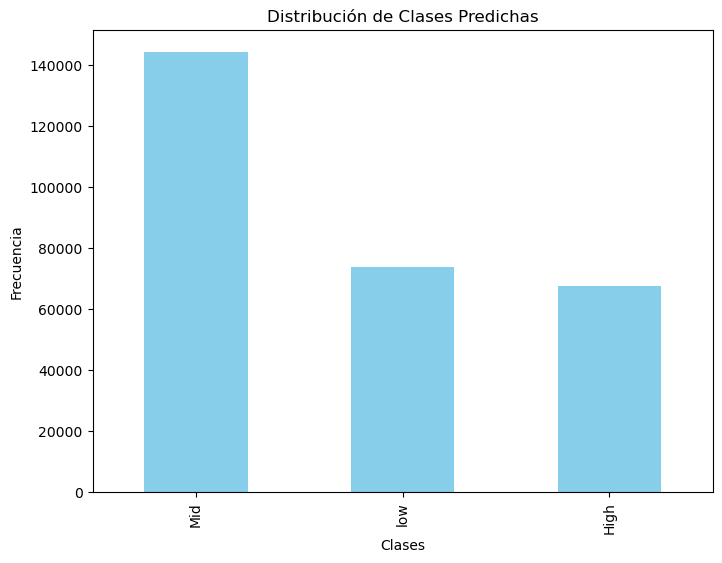

In [119]:
import matplotlib.pyplot as plt

pred_counts = wearable['Predicted_Class'].value_counts()
labels = {0: 'Mid', 1: 'low', 2: 'High'}  
# Graficar la distribución
plt.figure(figsize=(8, 6))
pred_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases Predichas')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.xticks(ticks=pred_counts.index, labels=[labels[i] for i in pred_counts.index])
plt.show()

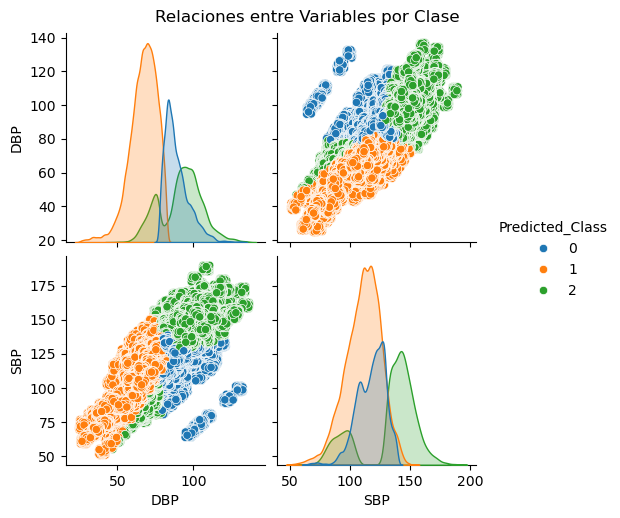

In [121]:

sns.pairplot(wearable, vars=cols, hue='Predicted_Class', palette='tab10', diag_kind='kde')
plt.suptitle('Relaciones entre Variables por Clase', y=1.02)
plt.show()

El modelo esta clasificando correctamente los datos en función de DBP y SBP. Donde 
<ol>
    <li>La clase  0  (azul) representa la etiqueta mid, con presión arterial en el límite.</li>
    <li>La clase 1 (naranja) representa la clase low, con los valores más bajos de presión.</li>
    <li>La clase 2 (verde) están valores altos de DBP y SBP, que son pacientes con mayor riesgo.</li>
</ol>

In [122]:
wearable.to_csv('unknownAgeWearablePredictions.csv', index=False)

## PRUEBA CON CASO LÍMITE

In [57]:
extremeCase = pd.read_csv('wearable_MaternalRiskDataset_EXTREME_CASE.csv')

In [59]:
extremeCase

,PATIENT,DATE,BMI,DBP,Glucose,HeartRate,SBP,TRIMESTER,BodyTemperature
0,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 10:34:58+00:00,24.7,71.178908,79.831179,114.838581,100.268811,1,37.374863
1,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 18:34:58+00:00,24.7,65.962812,74.859087,108.726190,92.726731,1,37.396294
2,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 02:34:58+00:00,24.7,70.005049,82.893106,114.925831,100.203023,1,37.305957
3,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 10:34:58+00:00,24.7,71.682904,83.399110,116.286471,101.138374,1,37.364837
4,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 18:34:58+00:00,24.7,62.492963,74.590061,106.666019,90.652381,1,37.322765
...,...,...,...,...,...,...,...,...,...
285467,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-15 21:49:39+00:00,24.8,86.715237,118.954019,111.153341,126.668632,3,37.091396
285468,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 05:49:39+00:00,24.8,95.012159,119.079043,120.751634,133.532145,3,36.857251
285469,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 13:49:39+00:00,24.8,93.703150,117.198304,111.686933,127.233104,3,37.072783
285470,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 21:49:39+00:00,24.8,87.916110,119.355192,111.534658,125.608165,3,37.136600


In [61]:
cols_to_scale = ['DBP', 'SBP']
extremeCase_scaled = extremeCase.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
extremeCase_scaled[cols_to_scale] = scaler.fit_transform(extremeCase_scaled[cols_to_scale])
print(extremeCase_scaled.head())

                                PATIENT                       DATE   BMI  \
0  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 10:34:58+00:00  24.7   
1  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 18:34:58+00:00  24.7   
2  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 02:34:58+00:00  24.7   
3  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 10:34:58+00:00  24.7   
4  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 18:34:58+00:00  24.7   

        DBP    Glucose   HeartRate       SBP  TRIMESTER  BodyTemperature  
0 -0.469712  79.831179  114.838581 -0.918765          1        37.374863  
1 -0.802845  74.859087  108.726190 -1.308710          1        37.396294  
2 -0.544682  82.893106  114.925831 -0.922167          1        37.305957  
3 -0.437524  83.399110  116.286471 -0.873806          1        37.364837  
4 -1.024452  74.590061  106.666019 -1.415959          1        37.322765  


In [63]:
from tensorflow.keras.models import load_model
import numpy as np
#model = load_model('mlp-model.keras')

cols = ['DBP', 'SBP']
X_scaled = extremeCase_scaled[cols].values
y_pred_prob=model.predict(X_scaled)
y_pred_encoded = np.argmax(y_pred_prob, axis=1) #etiquetas predichas

#decodificamos etiquetas
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train_categorical.argmax(axis=1))  # Ajustar el encoder con las clases originales
y_pred = label_encoder.inverse_transform(y_pred_encoded)
X_original = scaler.inverse_transform(X_scaled)

# 5. Añadir las predicciones al dataset
extremeCase_results = pd.DataFrame(X_original, columns=cols)  # Recuperar escala original
extremeCase_results['Predicted_Class'] = y_pred  # Agregar predicciones al DataFrame

8921/8921 ━━━━━━━━━━━━━━━━━━━━ 5s 567us/step


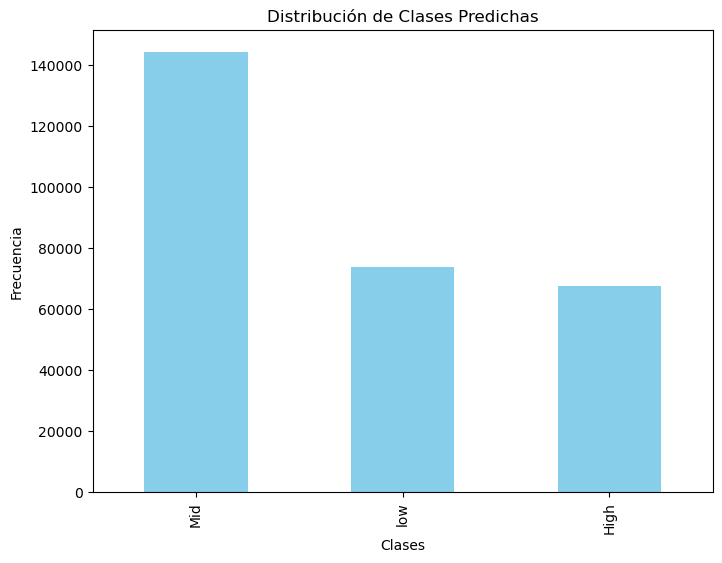

In [78]:
import matplotlib.pyplot as plt

pred_counts = extremeCase_results['Predicted_Class'].value_counts()
labels = {0: 'Mid', 1: 'low', 2: 'High'}  
# Graficar la distribución
plt.figure(figsize=(8, 6))
pred_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases Predichas')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
# Cambiar las etiquetas del eje X
plt.xticks(ticks=pred_counts.index, labels=[labels[i] for i in pred_counts.index])
plt.show()

Observamos que en este dataset, en el que se mezclan casos de preeclampsia con GDM, observamos no un gran número va a desarrollar preeclampsia, y no sabemos si es porque verdadareramente está así distribuido o que el modelo está sesgado con la clase Mid. Por ello vamos a probar con un dataset en el que sólo existan casos de preeclampsia con un número determinado de mujeres.  

# PRUEBA PARA MUJERES CON ALTO RIESGO DE PREECLAMPSIA

In [89]:
preeclampPatients = pd.read_csv('synthetic_preeclampsia_dataset.csv')

In [91]:
preeclampPatients

,PATIENT,DATE,BMI,DBP,Glucose,HeartRate,SBP,TRIMESTER,BodyTemperature,Risk_Level
0,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 10:34:58+00:00,27.168392,84.256066,106.670252,114.838581,120.509100,1,37.374863,High
1,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 18:34:58+00:00,24.700000,65.962812,74.859087,108.726190,92.726731,1,37.396294,Low
2,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 02:34:58+00:00,24.700000,70.005049,82.893106,114.925831,100.203023,1,37.305957,Low
3,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 10:34:58+00:00,24.700000,71.682904,83.399110,116.286471,101.138374,1,37.364837,Low
4,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 18:34:58+00:00,29.675599,81.941343,99.170511,106.666019,123.971732,1,37.322765,High
...,...,...,...,...,...,...,...,...,...,...
285467,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-15 21:49:39+00:00,27.467087,97.040240,147.608420,111.153341,159.789743,3,37.091396,High
285468,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 05:49:39+00:00,24.800000,95.012159,119.079043,120.751634,133.532145,3,36.857251,Low
285469,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 13:49:39+00:00,27.174557,104.679944,131.133734,111.686933,164.263907,3,37.072783,High
285470,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 21:49:39+00:00,24.800000,87.916110,119.355192,111.534658,125.608165,3,37.136600,Low


In [93]:
cols_to_scale = ['DBP', 'SBP']
preeclampPatients_scaled = preeclampPatients.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
preeclampPatients[cols_to_scale] = scaler.fit_transform(preeclampPatients_scaled[cols_to_scale])
print(preeclampPatients_scaled.head())

                                PATIENT                       DATE        BMI  \
0  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 10:34:58+00:00  27.168392   
1  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-10 18:34:58+00:00  24.700000   
2  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 02:34:58+00:00  24.700000   
3  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 10:34:58+00:00  24.700000   
4  07d072de-e7d4-7b46-3fc4-89e59f71eeee  2002-12-11 18:34:58+00:00  29.675599   

         DBP     Glucose   HeartRate         SBP  TRIMESTER  BodyTemperature  \
0  84.256066  106.670252  114.838581  120.509100          1        37.374863   
1  65.962812   74.859087  108.726190   92.726731          1        37.396294   
2  70.005049   82.893106  114.925831  100.203023          1        37.305957   
3  71.682904   83.399110  116.286471  101.138374          1        37.364837   
4  81.941343   99.170511  106.666019  123.971732          1        37.322765   

  Risk_Level  
0       High  
1 

In [95]:
from tensorflow.keras.models import load_model
import numpy as np


cols = ['DBP', 'SBP']
X_scaled = preeclampPatients_scaled[cols].values
y_pred_prob=model.predict(X_scaled)
y_pred_encoded = np.argmax(y_pred_prob, axis=1) #etiquetas predichas

#decodificamos etiquetas
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train_categorical.argmax(axis=1))  # Ajustar el encoder con las clases originales
y_pred = label_encoder.inverse_transform(y_pred_encoded)
X_original = scaler.inverse_transform(X_scaled)

# 5. Añadir las predicciones al dataset
preeclampPatients_results = pd.DataFrame(X_original, columns=cols)  # Recuperar escala original
preeclampPatients_results['Predicted_Class'] = y_pred  # Agregar predicciones al DataFrame

8921/8921 ━━━━━━━━━━━━━━━━━━━━ 5s 575us/step


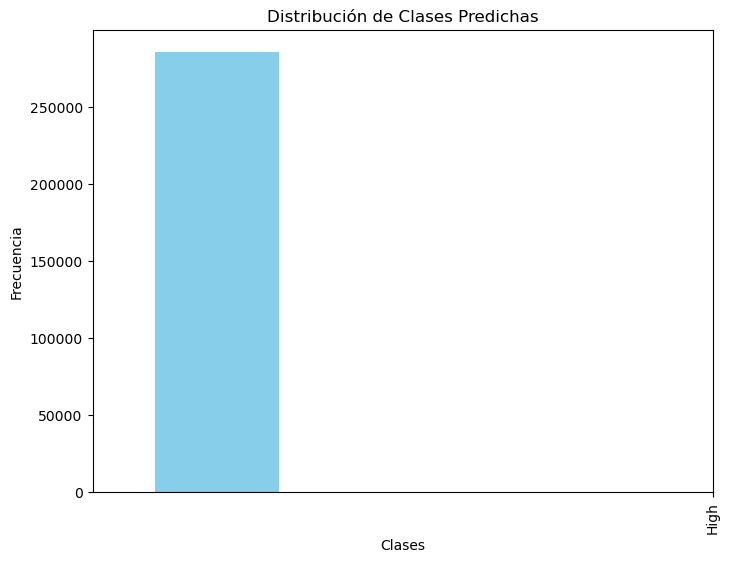

In [99]:
import matplotlib.pyplot as plt

pred_counts = preeclampPatients_results['Predicted_Class'].value_counts()
labels = {0: 'Mid', 1: 'low', 2: 'High'}  
# Graficar la distribución
plt.figure(figsize=(8, 6))
pred_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases Predichas')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
# Cambiar las etiquetas del eje X
plt.xticks(ticks=pred_counts.index, labels=[labels[i] for i in pred_counts.index])
plt.show()

En este caso hemos forzado que el 70% de las usuarias tenga alto riesgo de preeclampsia, aunque el modelo reconoce como que todas tienen preeclampsia, vemos que el modelo no está sesgado a una sola clase pero que tampoco es tán preciso pese a tener una alta accuracy. Esto puede deberse a que sólo dos parámetros hace que el modelo sea muy simple y no aprenda bien los patrones o que necesitemos más datos. 

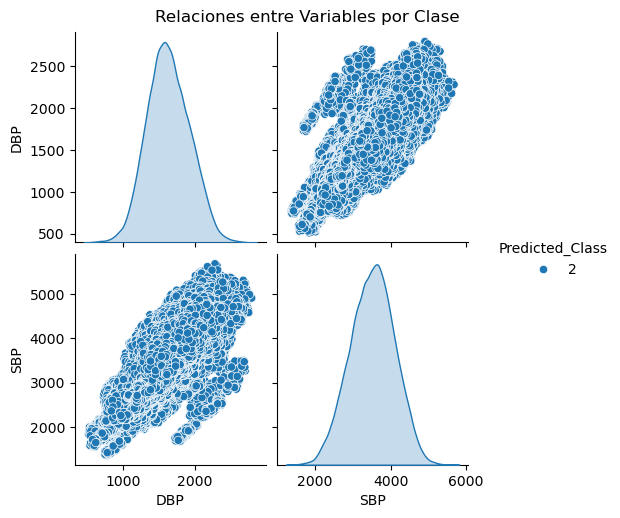

In [101]:
sns.pairplot(preeclampPatients_results, vars=cols, hue='Predicted_Class', palette='tab10', diag_kind='kde')
plt.suptitle('Relaciones entre Variables por Clase', y=1.02)
plt.show()